## A. Importing the required Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # to use operating system dependent functionality
import librosa # to extract speech features
import wave # read and write WAV files
import matplotlib.pyplot as plt # to generate the visualizations

# MLP Classifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# LSTM Classifier
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import rmsprop

Using TensorFlow backend.


## B. Reading the Dataset & Feature Extraction

In [2]:
def extract_mfcc(wav_file_name):
    #This function extracts mfcc features and obtain the mean of each dimension
    #Input : path_to_wav_file
    #Output: mfcc_features'''
    y, sr = librosa.load(wav_file_name)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
    
    return mfccs

In [3]:
##### load radvess speech dataset #####
radvess_speech_labels = [] # to save extracted label/file
ravdess_speech_data = [] # to save extracted features/file
for dirname, _, filenames in os.walk('/kaggle/input/ravdess-emotional-speech-audio/'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        radvess_speech_labels.append(int(filename[7:8]) - 1) # the index 7 and 8 of the file name represent the emotion label
        wav_file_name = os.path.join(dirname, filename)
        ravdess_speech_data.append(extract_mfcc(wav_file_name)) # extract MFCC features/file
        
print("Finish Loading the Dataset")

Finish Loading the Dataset


In [4]:
#### convert data and label to array
ravdess_speech_data_array = np.asarray(ravdess_speech_data) # convert the input to an array
ravdess_speech_label_array = np.array(radvess_speech_labels)
ravdess_speech_label_array.shape # get tuple of array dimensions

#### make categorical labels
labels_categorical = to_categorical(ravdess_speech_label_array) # converts a class vector (integers) to binary class matrix
ravdess_speech_data_array.shape
labels_categorical.shape

(2880, 8)

## C. Train and Test MLP Classifier

In [5]:
x_train,x_test,y_train,y_test= train_test_split(np.array(ravdess_speech_data_array),labels_categorical, test_size=0.20, random_state=9)

In [6]:
# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [7]:
# Train the model
model.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [8]:
# Predict for the test set
y_pred=model.predict(x_test)

In [9]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 49.31%


In [10]:
# Split the training, validating, and testing sets
number_of_samples = ravdess_speech_data_array.shape[0]
training_samples = int(number_of_samples * 0.8)
validation_samples = int(number_of_samples * 0.1)
test_samples = int(number_of_samples * 0.1)

In [11]:
# Define the LSTM model
def create_model_LSTM():
    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=(40, 1)))
    model.add(Dense(64))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(8))
    model.add(Activation('softmax'))
    
    # Configures the model for training
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [12]:
### train using LSTM model
model_A = create_model_LSTM()
history = model_A.fit(np.expand_dims(ravdess_speech_data_array[:training_samples],-1), labels_categorical[:training_samples], validation_data=(np.expand_dims(ravdess_speech_data_array[training_samples:training_samples+validation_samples], -1), labels_categorical[training_samples:training_samples+validation_samples]), epochs=100, shuffle=True)

Train on 2304 samples, validate on 288 samples
Epoch 1/100
2304/2304 [==============================] - 3s 1ms/step - loss: 2.0730 - accuracy: 0.1419 - val_loss: 2.0373 - val_accuracy: 0.1493
Epoch 2/100
2304/2304 [==============================] - 3s 1ms/step - loss: 2.0074 - accuracy: 0.1957 - val_loss: 1.9865 - val_accuracy: 0.2014
Epoch 3/100
2304/2304 [==============================] - 3s 1ms/step - loss: 1.9618 - accuracy: 0.2209 - val_loss: 1.9600 - val_accuracy: 0.2118
Epoch 4/100
2304/2304 [==============================] - 3s 1ms/step - loss: 1.9162 - accuracy: 0.2591 - val_loss: 1.9767 - val_accuracy: 0.2326
Epoch 5/100
2304/2304 [==============================] - 3s 1ms/step - loss: 1.9062 - accuracy: 0.2496 - val_loss: 1.9149 - val_accuracy: 0.2500
Epoch 6/100
2304/2304 [==============================] - 3s 1ms/step - loss: 1.8705 - accuracy: 0.2773 - val_loss: 1.9179 - val_accuracy: 0.2604
Epoch 7/100
2304/2304 [==============================] - 3s 1ms/step - loss: 1.8407

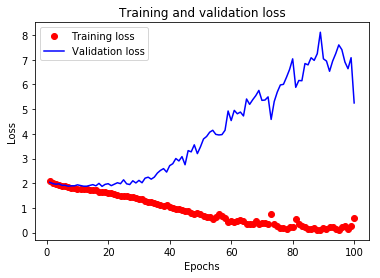

In [13]:
### loss plots using LSTM model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

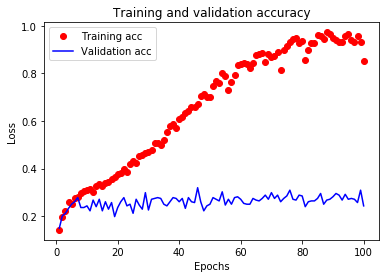

In [14]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [15]:
### evaluate using model A
model_A.evaluate(np.expand_dims(ravdess_speech_data_array[training_samples + validation_samples:], -1), labels_categorical[training_samples + validation_samples:])

288/288 [==============================] - 0s 276us/step


[5.231356249915229, 0.2569444477558136]